# ResNet50 Waste Classification Notebook

## Introduction

This notebook implements a deep learning model for waste classification using the ResNet50 architecture. The model is fine-tuned on a dataset of waste images categorized into paper, plastic, and aluminum.

Key features:
- Fine-tuning of pre-trained ResNet50
- Data augmentation and class weight balancing
- Early stopping and learning rate scheduling
- Comprehensive evaluation with confusion matrix and metrics

## Dependencies

The following cells install the necessary Python packages, including PyTorch with CUDA support for GPU acceleration.

In [ ]:
# Install PyTorch with CUDA support for GPU acceleration
# This installs PyTorch with CUDA 12.1 support. For other CUDA versions, visit https://pytorch.org/get-started/locally/
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cu121"])
print("PyTorch with CUDA 12.1 installed successfully!")

PyTorch with CUDA 12.1 installed successfully!


In [2]:
%pip install scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# ResNet50 Waste Classification Model

## Overview
This notebook implements a fine-tuned ResNet50 model for waste classification (Paper, Plastic, Aluminum) with advanced training techniques including early stopping, class weight balancing, and comprehensive metrics tracking.

---

## Cell 1: Setup & Configuration

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import time
import numpy as np

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_DIR = '../Public_dataset'      # Folder containing paper, plastic, aluminum
BATCH_SIZE = 8             # Reduced slightly for 512x512 images to avoid memory errors
LEARNING_RATE = 1e-4        # Lower learning rate for fine-tuning
NUM_EPOCHS = 15
NUM_CLASSES = 3             # paper, plastic, aluminum
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early Stopping Configurationa
PATIENCE = 5                # Number of epochs to wait before stopping
MIN_DELTA = 0.001          # Minimum change to qualify as an improvement

print(f"Using device: {DEVICE}")

Using device: cuda


## Cell 2: Data Preparation with Class Weight Analysis

This section loads the dataset and automatically calculates class weights to handle imbalanced data.

In [4]:
# Training transforms: Resize + Augmentation (Flip, Rotate, Color Jitter)
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Adds robustness to lighting
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transforms: Resize only
val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # Load dataset twice: once for train (with augmentation), once for val (clean)
    full_data_train = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    full_data_val = datasets.ImageFolder(DATA_DIR, transform=val_transform)

    # Get class names
    class_names = full_data_train.classes
    print(f"Classes detected: {class_names}")

    # Create indices for split (80% Train, 20% Val)
    train_idx, val_idx = train_test_split(
        list(range(len(full_data_train))),
        test_size=0.2,
        random_state=42
    )

    # Create subsets
    train_dataset = Subset(full_data_train, train_idx)
    val_dataset = Subset(full_data_val, val_idx)

    # Data Loaders
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    }
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    
    print(f"Training on {dataset_sizes['train']} images")
    print(f"Validating on {dataset_sizes['val']} images")

except Exception as e:
    print("\nERROR: Could not find dataset!")
    print(f"Make sure you have a folder named '{DATA_DIR}' with subfolders for each class.")
    exit()

# ==========================================
# CALCULATE CLASS WEIGHTS (Handle Imbalanced Data)
# ==========================================
print("\nCalculating class weights for imbalanced dataset...")

# Count samples per class in training set
class_counts = np.zeros(NUM_CLASSES)
for idx in train_idx:
    label = full_data_train.targets[idx]
    class_counts[label] += 1

print(f"Class distribution in training set:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {int(class_counts[i])} samples")

# Calculate weights inversely proportional to class frequency
# Gives more weight to underrepresented classes
total_samples = np.sum(class_counts)
class_weights = total_samples / (NUM_CLASSES * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print(f"\nClass weights (normalized):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weights[i]:.4f}")

Classes detected: ['aluminium', 'paper', 'plastic']
Training on 2147 images
Validating on 537 images

Calculating class weights for imbalanced dataset...
Class distribution in training set:
  aluminium: 617 samples
  paper: 835 samples
  plastic: 695 samples

Class weights (normalized):
  aluminium: 1.1599
  paper: 0.8571
  plastic: 1.0297


## Cell 3: Model Setup (ResNet50 + Dropout)

Initialize ResNet50 with pretrained ImageNet weights and add a custom classifier head.

In [5]:
print("\nInitializing ResNet50...")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the final layer (The Classifier)
# ResNet50's default input to the final layer is 2048 features
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),            # Strong dropout to prevent overfitting
    nn.Linear(num_ftrs, 512),   # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.3),            # Mild dropout
    nn.Linear(512, NUM_CLASSES) # Final output (3 classes)
)

model = model.to(DEVICE)


Initializing ResNet50...


## Cell 4: Training Setup with Early Stopping & Class Weights

Configure the loss function with class weights, optimizer, scheduler, and early stopping mechanism.

In [6]:
# ==========================================
# LOSS FUNCTION WITH CLASS WEIGHTS
# ==========================================
# CrossEntropyLoss with class weights to handle imbalanced data
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Adam optimizer is generally faster at converging than SGD
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler: if validation accuracy doesn't improve, lower the learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# ==========================================
# EARLY STOPPING CLASS
# ==========================================
class EarlyStopping:
    """
    Stops training when validation metric stops improving.
    Saves the best model weights.
    """
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None
        
    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.best_model_wts = model.state_dict().copy()
        elif val_acc > self.best_score + self.min_delta:
            self.best_score = val_acc
            self.counter = 0
            self.best_model_wts = model.state_dict().copy()
            if self.verbose:
                print(f"    ✓ Validation improved! New best accuracy: {val_acc:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"    ✗ No improvement. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"    ⚠ EARLY STOPPING TRIGGERED after {self.patience} epochs without improvement!")

# Initialize early stopping
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

# ==========================================
# TRAINING LOOP WITH METRICS TRACKING
# ==========================================
def train_model(model, criterion, optimizer, scheduler, early_stopping, num_epochs=10):
    """
    Train the model with early stopping and comprehensive metrics tracking.
    
    Tracks:
    - Loss & Accuracy
    - Precision, Recall, F1 Score
    - Best model checkpoint
    """
    since = time.time()
    
    best_acc = 0.0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        print(f'\n{"="*70}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*70}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            batch_count = 0
            
            # Store predictions and labels for metrics calculation
            all_preds = []
            all_labels = []

            # Iterate over data
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_count += 1
                
                # Store predictions and labels for metrics
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Print batch progress every 5 batches
                if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                    current_loss = running_loss / (batch_count * BATCH_SIZE)
                    current_acc = running_corrects.double() / (batch_count * BATCH_SIZE)
                    num_batches = len(dataloaders[phase])
                    print(f'  {phase.upper()} | Batch {batch_idx+1}/{num_batches} | Loss: {current_loss:.4f} | Acc: {current_acc:.4f}')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Calculate additional metrics
            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)
            
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            print(f'\n  {phase.upper()} SUMMARY')
            print(f'    Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
            print(f'    Precision: {epoch_precision:.4f} | Recall: {epoch_recall:.4f} | F1: {epoch_f1:.4f}')
            print(f'    Learning Rate: {current_lr:.2e}')
            
            # Store metrics in history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_precision'].append(epoch_precision)
            history[f'{phase}_recall'].append(epoch_recall)
            history[f'{phase}_f1'].append(epoch_f1)

            # Deep copy the model if it's the best one so far
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    print(f'  *** NEW BEST MODEL! Validation Accuracy: {epoch_acc:.4f} ***')
                
                # Check early stopping and step scheduler
                early_stopping(epoch_acc.item(), model)
                scheduler.step(epoch_acc)
                
                if early_stopping.early_stop:
                    print(f"\nTraining stopped early at epoch {epoch+1}/{num_epochs}")
                    break
        
        if early_stopping.early_stop:
            break

    time_elapsed = time.time() - since
    print(f'\n{"="*70}')
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print(f'{"="*70}')

    # Load best model weights
    model.load_state_dict(early_stopping.best_model_wts)
    return model, history

# ==========================================
# RUN & SAVE
# ==========================================
if __name__ == '__main__':
    # Train
    trained_model, training_history = train_model(model, criterion, optimizer, scheduler, early_stopping, NUM_EPOCHS)
    
    # Save
    save_path = 'waste_classifier_resnet50.pth'
    torch.save(trained_model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


Epoch 1/15
  TRAIN | Batch 1/269 | Loss: 1.0967 | Acc: 0.2500
  TRAIN | Batch 5/269 | Loss: 1.0964 | Acc: 0.3750
  TRAIN | Batch 10/269 | Loss: 1.0808 | Acc: 0.3750
  TRAIN | Batch 15/269 | Loss: 1.0785 | Acc: 0.3833
  TRAIN | Batch 20/269 | Loss: 1.0618 | Acc: 0.4000
  TRAIN | Batch 25/269 | Loss: 1.0527 | Acc: 0.4100
  TRAIN | Batch 30/269 | Loss: 1.0453 | Acc: 0.4042
  TRAIN | Batch 35/269 | Loss: 1.0431 | Acc: 0.4036
  TRAIN | Batch 40/269 | Loss: 1.0253 | Acc: 0.4438
  TRAIN | Batch 45/269 | Loss: 1.0030 | Acc: 0.4889
  TRAIN | Batch 50/269 | Loss: 0.9879 | Acc: 0.5100
  TRAIN | Batch 55/269 | Loss: 0.9669 | Acc: 0.5318
  TRAIN | Batch 60/269 | Loss: 0.9528 | Acc: 0.5417
  TRAIN | Batch 65/269 | Loss: 0.9381 | Acc: 0.5558
  TRAIN | Batch 70/269 | Loss: 0.9334 | Acc: 0.5661
  TRAIN | Batch 75/269 | Loss: 0.9186 | Acc: 0.5800
  TRAIN | Batch 80/269 | Loss: 0.8975 | Acc: 0.6016
  TRAIN | Batch 85/269 | Loss: 0.8769 | Acc: 0.6147
  TRAIN | Batch 90/269 | Loss: 0.8534 | Acc: 0.6306
  

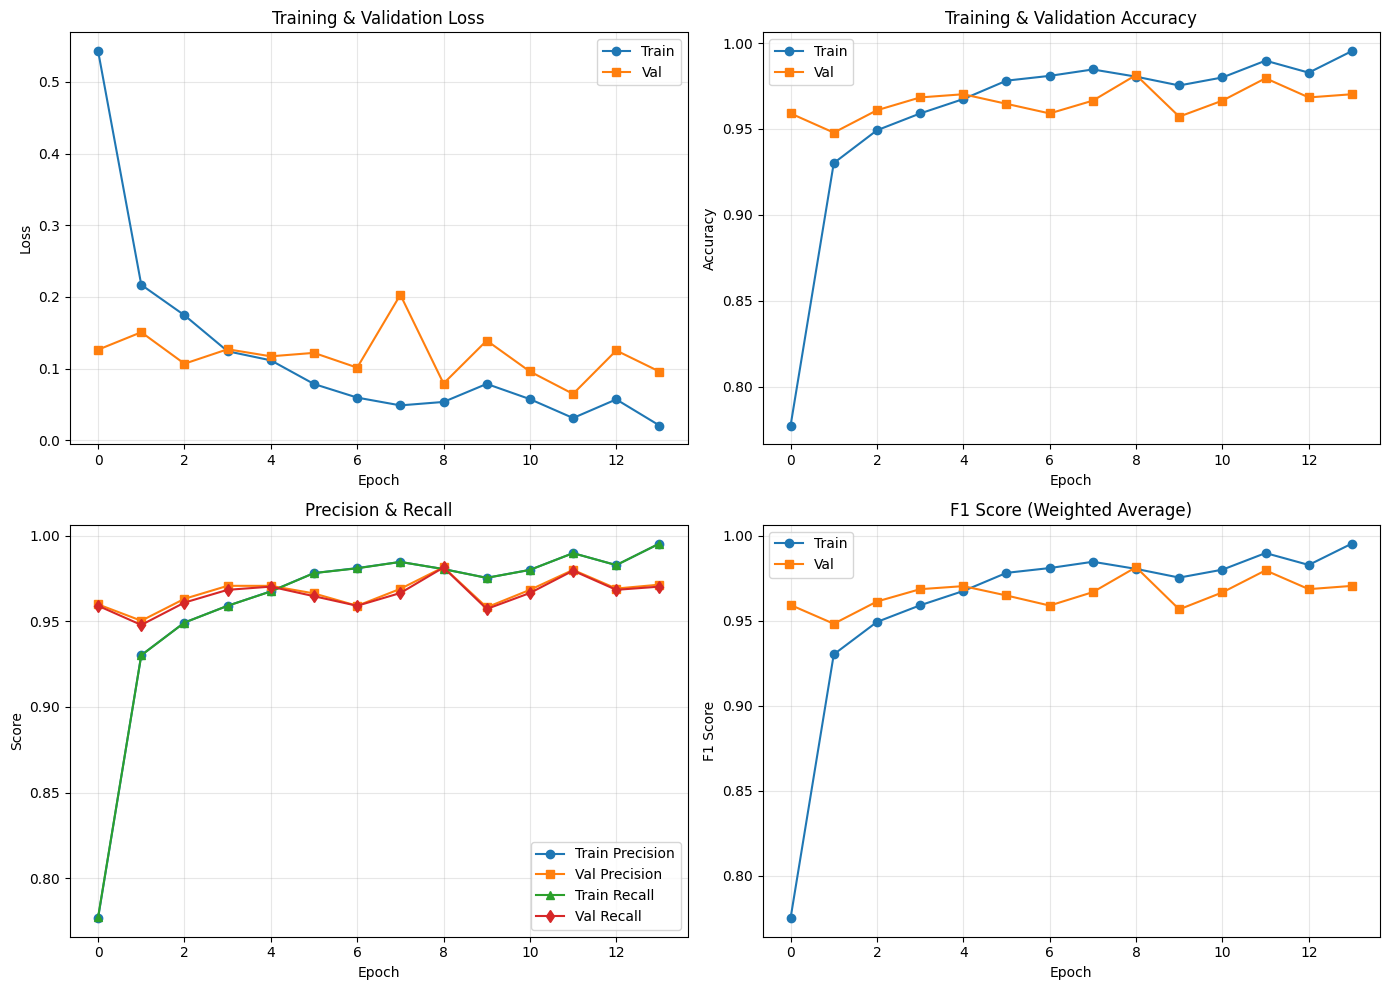

In [7]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss plot
axes[0, 0].plot(training_history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(training_history['val_loss'], label='Val', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(training_history['train_acc'], label='Train', marker='o')
axes[0, 1].plot(training_history['val_acc'], label='Val', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision, Recall, F1 plot
axes[1, 0].plot(training_history['train_precision'], label='Train Precision', marker='o')
axes[1, 0].plot(training_history['val_precision'], label='Val Precision', marker='s')
axes[1, 0].plot(training_history['train_recall'], label='Train Recall', marker='^')
axes[1, 0].plot(training_history['val_recall'], label='Val Recall', marker='d')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision & Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 Score plot
axes[1, 1].plot(training_history['train_f1'], label='Train', marker='o')
axes[1, 1].plot(training_history['val_f1'], label='Val', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score (Weighted Average)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_18039/3220192020.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(model_path, map_location=DEVICE)


Loading from state_dict...
✓ Model loaded from waste_classifier_resnet50.pth
✓ Test dataset loaded from ../Dataset/
  Classes: ['aluminium', 'paper', 'plastic']
  Total images: 512

EVALUATING MODEL ON SELF-COLLECTED TEST SET

✓ Predictions saved to predictions_test.csv

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   aluminium     0.7126    0.4882    0.5794       127
       paper     0.4367    0.8675    0.5809       151
     plastic     0.7600    0.4060    0.5292       234

    accuracy                         0.5625       512
   macro avg     0.6364    0.5872    0.5632       512
weighted avg     0.6529    0.5625    0.5569       512


CONFUSION MATRIX:


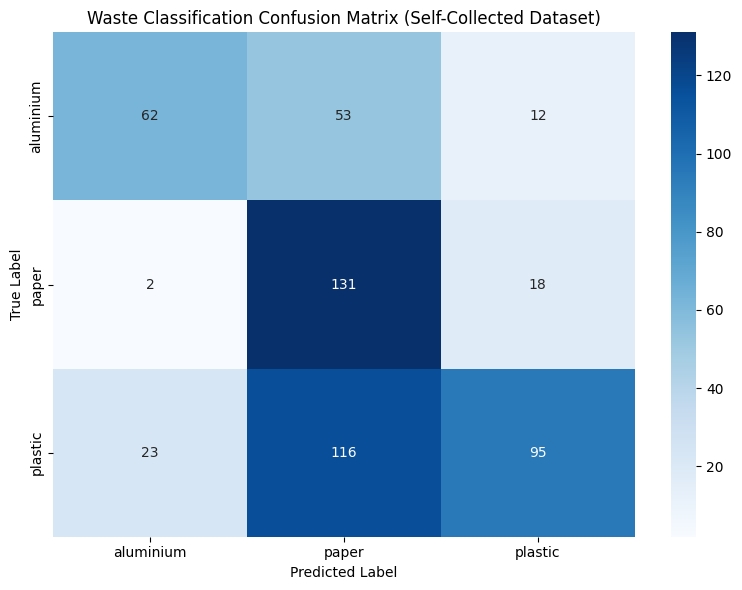


PER-CLASS ACCURACY
  aluminium: 0.4882 (62/127)
  paper: 0.8675 (131/151)
  plastic: 0.4060 (95/234)

✓ Overall Accuracy: 0.5625

Weighted Metrics:
  Precision: 0.6529
  Recall: 0.5625
  F1-Score: 0.5569


In [4]:
# ==========================================
# STANDALONE MODEL EVALUATION CELL
# This cell can run independently without running previous cells
# ==========================================

import torch
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os
import pandas as pd


# ==========================================
# MODEL EVALUATION & CONFUSION MATRIX
# ==========================================

def evaluate_model(model, dataloader, class_names, device):
    """
    Evaluate the model and return predictions, labels, and metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ==========================================
# LOAD MODEL & EVALUATE ON TEST SET
# ==========================================

# Configuration
model_path = 'waste_classifier_resnet50.pth'
test_data_dir = '../Dataset/'  # Self-collected test dataset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_CLASSES = 3

# Validation transform (no augmentation for testing)
val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the trained model
if not os.path.exists(model_path):
    print(f"❌ Model file {model_path} not found!")
    print("Please train the model first by running the training cell above.")
else:
    # Load model (could be full model or state_dict)
    loaded = torch.load(model_path, map_location=DEVICE)
    
    if isinstance(loaded, dict):
        # It's a state_dict, recreate model
        print("Loading from state_dict...")
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )
        model.load_state_dict(loaded)
    else:
        # It's the full model
        model = loaded
    
    model.to(DEVICE)
    model.eval()
    print(f"✓ Model loaded from {model_path}")

    # Create test dataloader for self-collected dataset
    test_dataset = datasets.ImageFolder(test_data_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    class_names = test_dataset.classes
    
    print(f"✓ Test dataset loaded from {test_data_dir}")
    print(f"  Classes: {class_names}")
    print(f"  Total images: {len(test_dataset)}")

    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING MODEL ON SELF-COLLECTED TEST SET")
    print("="*70)
    preds, labels = evaluate_model(model, test_loader, class_names, DEVICE)

    # Save predictions to CSV
    predictions_df = pd.DataFrame({
        'True Label': [class_names[label] for label in labels],
        'Predicted Label': [class_names[pred] for pred in preds]
    })
    predictions_df.to_csv('predictions_test.csv', index=False)
    print("\n✓ Predictions saved to predictions_test.csv")

    # Calculate confusion matrix
    cm = confusion_matrix(labels, preds)

    # Print classification report
    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)
    report = classification_report(labels, preds, target_names=class_names, digits=4)
    print(report)

    # Plot confusion matrix
    print("\nCONFUSION MATRIX:")
    plot_confusion_matrix(cm, class_names, title='Waste Classification Confusion Matrix (Self-Collected Dataset)')

    # Calculate per-class accuracy
    print("\n" + "="*70)
    print("PER-CLASS ACCURACY")
    print("="*70)
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name}: {class_accuracy:.4f} ({cm[i, i]}/{cm[i, :].sum()})")

    # Overall accuracy
    overall_accuracy = np.trace(cm) / np.sum(cm)
    print(f"\n✓ Overall Accuracy: {overall_accuracy:.4f}")

    # Additional metrics
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average='weighted')
    print(f"\nWeighted Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("="*70)